<h1 style="padding: 10px; color: blue; font-size: 28pt; font-family: tahoma">
    MULTI-STORE DEMAND PREDICTION 
</h1>
 <br>

<img src='images/banner.jfif' />

<h2 style="background-color: blue; padding: 10px; color: white; font-size: 18pt; font-family: tahoma">
    1.0 INTRODUCTION
</h2>

Lead time in e-commerce refers to the entire amount of time an eCommerce seller spends filling an order, measured from the time a consumer puts an order on the seller's website or mobile application until the customer receives the goods. Long lead times are one of the biggest drawbacks of the ecommerce industry in many developing countries. The typical lead time promised by online stores in Nigeria is between 4 and 6 days. This makes them undesirable for shopping of urgently needed goods. Reducing lead times have a number of advantages, including increased customer satisfaction, sales growth, competitive advantage, Efficiency gain etc.

The distance between the consumer and the item's physical location is a key detreminant of lead times. A buyer who lives within 100 kilometers of an item will probably receive it sooner than someone who lives 1000 kilometers away. As a result, cutting down on the distance between a client and an item will most likely cut down on the lead time made available to that customer. Operating a number of strategically placed warehouses in close proximity to the clients is one way to shorten the distance. Nigeria, for example, has six zones, and having a warehouse in each zone automatically shortens the distance to the customers. However, this strategy will only work if the warehouses are adequately supplied before the orders arrive. However, this strategy will only work if the warehouses are adequately supplied before the orders arrive. To prestock a warehouse, the e-commerce business needs to know how much of each product will be needed at specific times in each warehouse so that products won't be needed in one store but only be available in another far-off store. 

The aim of this project is to develope a system which is capable of predicting the number of demand for each item at different stores with a view to reduce the lead times offered by online stores. Hence, this notebook focuses on the training of a multi-store multi-item demand prediction model using the kaggle Store Item Demand Forecasting Challenge dataset which can be found <a href="https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data"> here </a>

<br>
<h2 style="background-color: blue; padding: 10px; color: white; font-size: 18pt; font-family: tahoma">
    2.0 IMPORTING LIBRARIES
</h2>

In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle as pkl

<br>
<h2 style="background-color: blue; padding: 10px; color: white; font-size: 18pt; font-family: tahoma">
    3.0 THE DATASET
</h2>

## 3.1 Dataset Overview

The dataset contains three files; the train.csv and test.csv both of which are provided in the datasets sub-folder accompanying this notebook.

Within this files you will find the following fields:

- date - Date of the sale data. There are no holiday effects or store closures.
- store - Store ID
- item - Item ID
- sales - Number of items sold at a particular store on a particular date.

## 3.2 Loading the dataset

In [162]:
# load the train dataset
df_train = pd.read_csv('datasets/train.csv', parse_dates=['date'])

# load the test dataset
df_test = pd.read_csv('datasets/test.csv', parse_dates=['date'])

<br>
<h2 style="background-color: blue; padding: 10px; color: white; font-size: 18pt; font-family: tahoma">
    4.0 EXPLORATORY DATA ANALYSIS
</h2>

Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns, to spot anomalies, to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

## 4.1 Basic Dataset Statistics

In [24]:
# display the first few rows of the train dataset
df_train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [25]:
# display the last few rows of the train dataset
df_train.tail()

,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


The dataset contains sales records from the 01-01-2013 to 31-12-2017 which is exactly five years.

In [26]:
# display basic dataset information
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


The dataset is fairly small containing four columns and 913,000 sales record. It does not contain null entries and they are intuitively in the right datatype and the date feature which might be needing to be coverted to pandas date format has been converted to datetime; There are three numerical columns and one datetime.

In [27]:
# view dataset statistical description 
desc = df_train.describe().T
desc

,count,mean,std,min,25%,50%,75%,max
store,913000.0,5.500000,2.872283,1.0,3.0,5.5,8.0,10.0
item,913000.0,25.500000,14.430878,1.0,13.0,25.5,38.0,50.0
sales,913000.0,52.250287,28.801144,0.0,30.0,47.0,70.0,231.0


Text(0.5, 0, 'features')

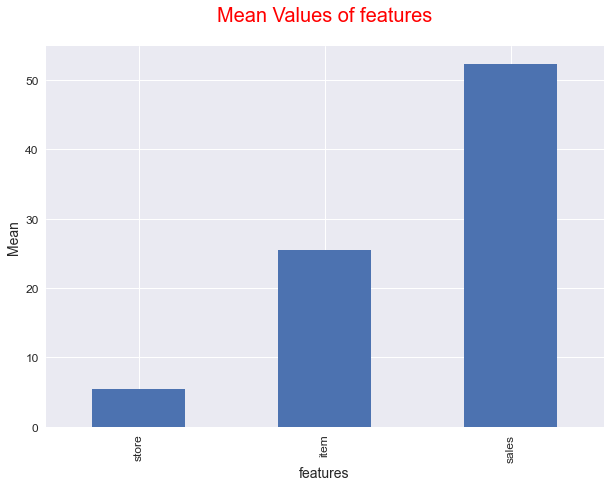

In [41]:
plt.style.use('seaborn')
desc['mean'].plot(kind='bar', figsize=(10,7), fontsize=12)
desc['std'].plot(kind='bar', figsize=(10,7), fontsize=12)
plt.title("Mean Values of features", fontsize=20, color='red', y=1.05)
plt.ylabel('Mean', fontsize=14)
plt.xlabel('features', fontsize=14)

The statistical discription of the properties indicated that the mean of the store and items attributes are widely variant. An effect of this variation would be the creation of a model where the item attribute has larger influence than the store attributes on the predicted sales. Although, by mere looking, we cannot be certain which of these features contribute more. Even when we are aware that these features are IDs, the model might not be able to detect them as such. Hence, it would be required that those features to either be scaled or encoded.

## 4.2 Distribution of Dataset

There is a need to investigate how the stores, items and sales are diastributed. This is to have an idea of how the stores and items are being represented in the dataset. Underrepresentation or overrepresentation of items and stores can have negative impact on the model. 

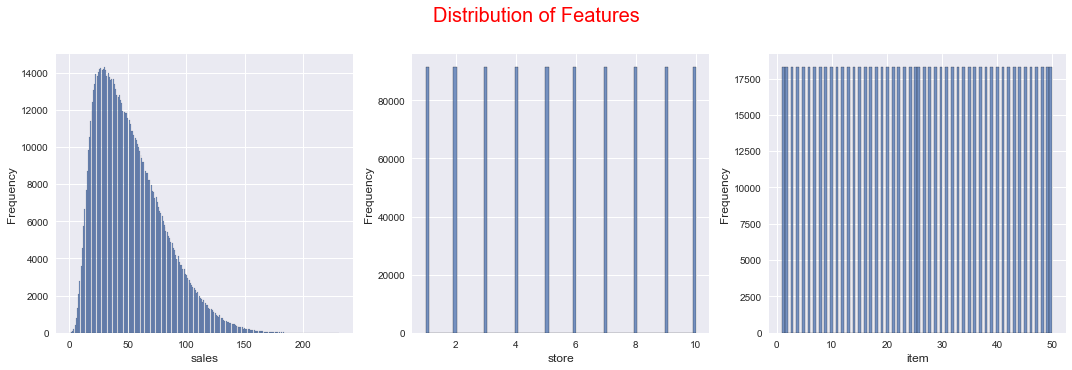

In [29]:
fig, ax = plt.subplots(nrows= 1, ncols=3, figsize = (15, 5))
cols = df_train[['sales', 'store', 'item']].columns

for i in range(len(cols)):
    sns.histplot(df_train[cols[i]], ax=ax[i])
    ax[i].set_ylabel('Frequency', fontsize=12)
    ax[i].set_xlabel(cols[i], fontsize=12)
    
fig.suptitle('Distribution of Features', fontsize=20, color="red", y=1.02)
plt.tight_layout()
plt.show()

The store and the items dataset are uniformly distributed. It means that there are equal number of examples of stores and items in the dataset. Every store is represented about 9000 times and each item is represented about 18000 times. The sales is slighly skewed to the right. Most of the sales occur within the 0 to 100 interval. Although there are some sales outside that range which might be needing verification of wether they should be classed as outliers or not.

## 4.3 Detection of Outliers

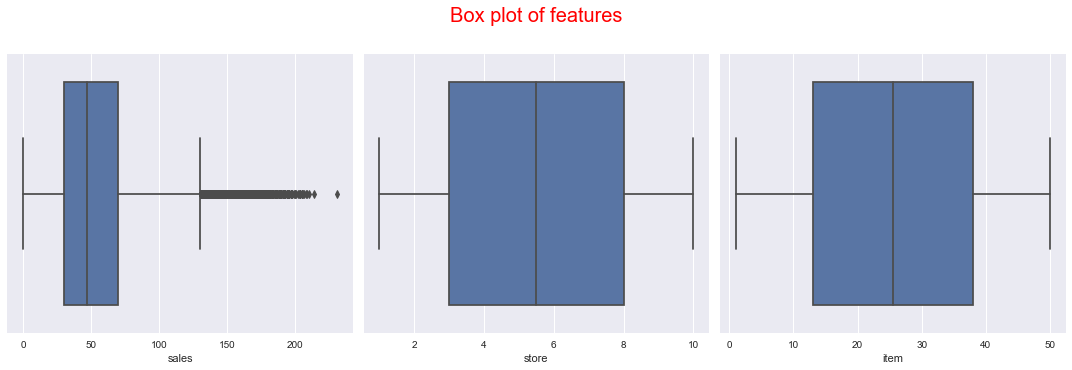

In [30]:
fig, ax = plt.subplots(nrows= 1, ncols=3, figsize = (15, 5))
cols = df_train[['sales', 'store', 'item']].columns

for i in range(len(cols)):
    sns.boxplot(x=df_train[cols[i]], data=df_train, ax=ax[i])
    
fig.suptitle('Box plot of features', fontsize=20, color="red", y=1.02)
plt.tight_layout()
plt.show()

From the box plot of the sales feature, we could see values which are well outside the maximum range. These values might and might not be outliers. There could have been several factors which could have influenced the high sales recorded. Some of those factors could have been seasonality; some products will sell excessively during some periods, another factor can be the kind of item; some items might be in excessively high demands during some events, it could also be due to the location of some stores; some stores might be selling excessively high due to thier locations. Hence, before it is decided whether they are outliers or not, we will need to verify the following;
- Are the abnormally high sales occuerent in particular stores?
- Are those values related to some particular products
- Are those sales observed at reoccurent time or in patterened interval?

If any of these questions are true then, we can consider the values as part of our dataset. Else, we might need to drop them because we do not have other features in our datasets to explain their existence and they might hurt our model. 

## 4.4 Store-wise and Product-wise Sales Analysis

Some of the questions asked above can be answered by looking at the store-wise distribution of sales. Although, to have non-clustetred scattered plots, we limit the sales values plotted to values above 120; this range is close to what was flagged as being outliers.

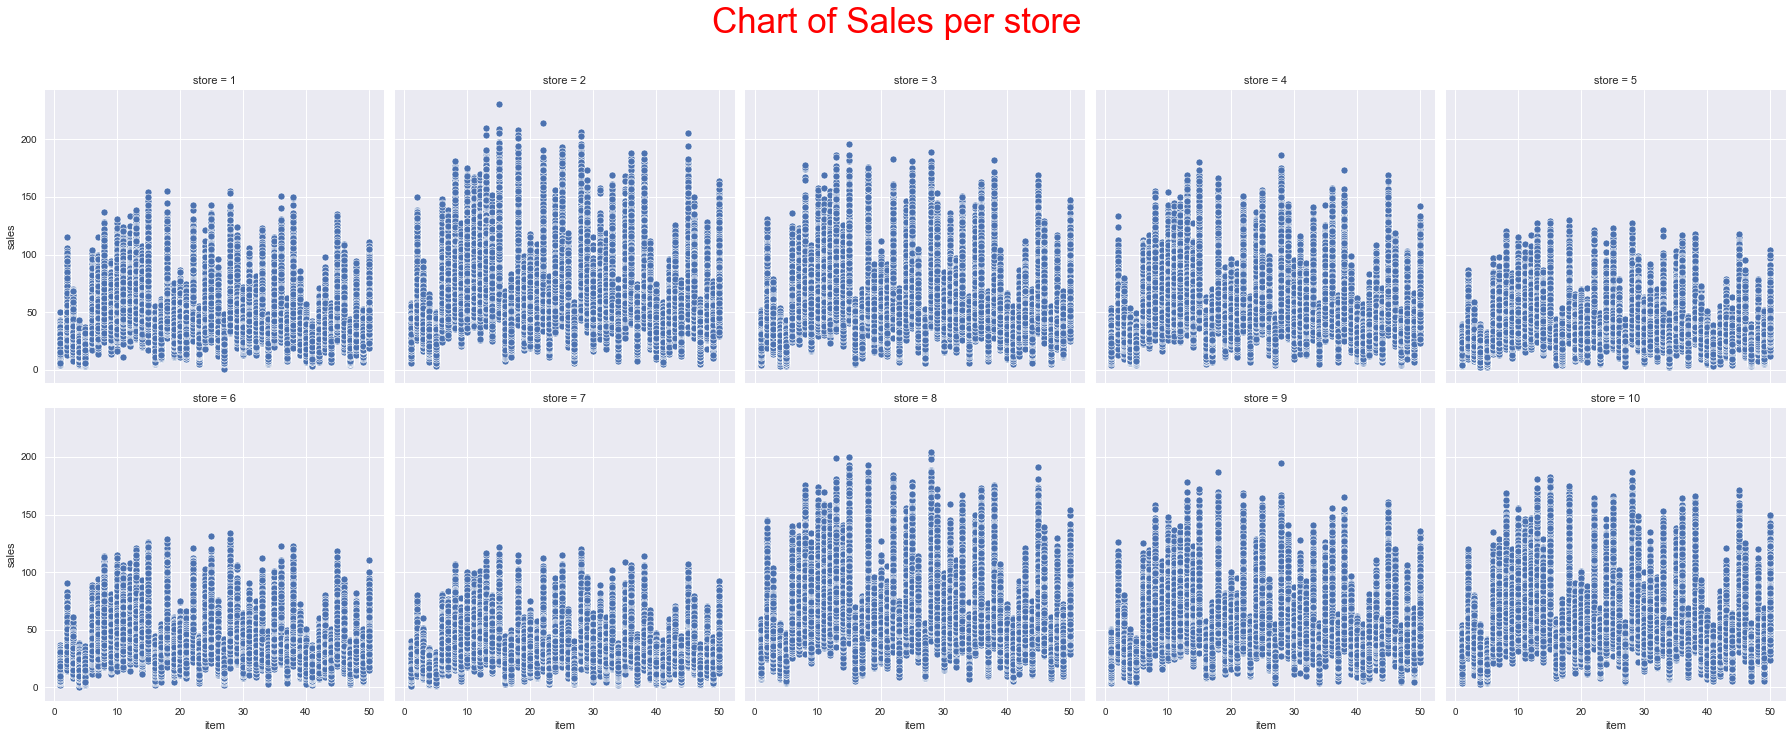

In [42]:
sns.relplot(x='item', y='sales', data=df_train, col='store', col_wrap=5)
plt.suptitle("Chart of Sales per store", fontsize=35, color="red", y=1.02)
plt.tight_layout()
plt.show()

From the charts above, we can quickly see that the high sales values are really not isolated - They atre not very distant from their neighboring values. Hence, they do not seem out of place in the dataset and should not be considered as outliers. Another supportive consideration is that, those high sales values are store dependent. Majority of them occuring in store 2 and in store 8. 

In [32]:
# create a table of store-wise sales statistic
df_train.groupby('store').agg({'sales': ['count', 'sum', 'mean', 'std', 'min', 'max']})

sales                                        
       count      sum       mean        std min  max
store                                               
1      91300  4315603  47.268379  24.006252   1  155
2      91300  6120128  67.033165  33.595810   3  231
3      91300  5435144  59.530602  29.974102   3  196
4      91300  5012639  54.902946  27.733097   4  186
5      91300  3631016  39.770164  20.365757   2  130
6      91300  3627670  39.733516  20.310451   0  134
7      91300  3320009  36.363735  18.684825   1  122
8      91300  5856169  64.142048  32.231751   4  204
9      91300  5025976  55.049025  27.832186   4  195
10     91300  5360158  58.709288  29.554994   3  187

Similar to our initial results, store 2 and 8 have the highest sales total across all products. It is not surprising that they record some of the highest individual sales value for product. A peak at the standard deviation for those store does not look far fetched from what is obtainable in the other stores.

In [33]:
# create a table of store-wise sales statistic
df_train.groupby('item').agg({'sales': ['count', 'sum', 'mean', 'std', 'min', 'max']})

sales                                        
      count      sum       mean        std min  max
item                                               
1     18260   401384  21.981599   8.468922   1   59
2     18260  1069564  58.574151  20.093015   9  150
3     18260   669087  36.642223  13.179441   7  104
4     18260   401907  22.010241   8.403898   0   66
5     18260   335230  18.358708   7.265167   1   50
6     18260  1068281  58.503888  20.174898  11  148
7     18260  1068777  58.531051  20.146002  11  141
8     18260  1405108  76.950055  26.130697  15  181
9     18260   938379  51.389869  17.790158   6  134
10    18260  1337133  73.227437  24.823725  14  175
11    18260  1271925  69.656353  23.744732  11  170
12    18260  1271534  69.634940  23.738663  12  170
13    18260  1539621  84.316594  28.311031  20  210
14    18260  1071531  58.681873  20.079860  12  152
15    18260  1607442  88.030778  29.522852  17  231
16    18260   468480  25.656079   9.603270   2   70
17    18260   602486  32.994852  11.967610   4   83
18    18260  1538876  84.275794  28.430621  18  208
19    18260   736892  40.355531  14.332645   5   99
20    18260   867641  47.515936  16.490487   9  127
21    18260   736190  40.317087  14.338006   7  109
22    18260  1469971  80.502245  27.118163  14  214
23    18260   534979  29.297864  10.819549   3   81
24    18260  1205975  66.044633  22.531555  14  156
25    18260  1473334  80.686418  27.238817  18  193
26    18260   869981  47.644085  16.723912   8  119
27    18260   402628  22.049726   8.461641   1   59
28    18260  1604713  87.881325  29.501781  16  206
29    18260  1271240  69.618839  23.635631  15  173
30    18260   736554  40.337021  14.363331   5  115
31    18260  1070845  58.644304  20.104705  10  159
32    18260   803107  43.981763  15.574556   5  119
33    18260  1270183  69.560953  23.718343  15  169
34    18260   469935  25.735761   9.617910   2   79
35    18260  1201541  65.801807  22.461990  12  168
36    18260  1406548  77.028916  26.067440  16  188
37    18260   534258  29.258379  10.771547   3   74
38    18260  1470330  80.521906  27.141799  15  188
39    18260   801311  43.883406  15.511550   7  112
40    18260   534094  29.249398  10.822959   3   74
41    18260   401759  22.002136   8.402470   2   60
42    18260   669925  36.688116  13.215112   5   96
43    18260   936635  51.294359  17.801008   9  126
44    18260   536811  29.398193  10.797738   3   78
45    18260  1471467  80.584173  27.318402  18  205
46    18260  1070764  58.639869  20.220879  11  150
47    18260   401781  22.003341   8.420102   2   61
48    18260   937703  51.352848  17.881917   8  130
49    18260   535663  29.335323  10.874788   3   77
50    18260  1203009  65.882202  22.416031  12  164

Across all stores, item 15 sold the most with a cummulative sales record of above 1.6 million. This item also has the highest individual sales record for an item.

## 4.5 Time-wise Sales Analysis

We have access to the date of product sales in the dataset. Although, it is provided as object field. Hence, we might want to create more time based fields to have more grannular time-wise analyis. We are provided with the date, the month and the year. But we might want to create several other time-fields like day of week, quarter, day of year etc. 

In [89]:
# copy the train dataset into a new dataframe
df_temp = df_train.copy()

In [90]:
# create more time related features
df_temp['year'] = df_temp.date.dt.year
df_temp['month'] = df_temp.date.dt.month
df_temp['day'] = df_temp.date.dt.day
df_temp['week'] = df_temp.date.dt.isocalendar().week
df_temp['day_of_week'] = df_temp.date.dt.day_of_week
df_temp['day_of_year'] = df_temp.date.dt.day_of_year
df_temp['quarter'] = df_temp.date.dt.quarter

In [78]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         913000 non-null  datetime64[ns]
 1   store        913000 non-null  int64         
 2   item         913000 non-null  int64         
 3   sales        913000 non-null  int64         
 4   year         913000 non-null  int64         
 5   month        913000 non-null  int64         
 6   day          913000 non-null  int64         
 7   week         913000 non-null  UInt32        
 8   day_of_week  913000 non-null  int64         
 9   day_of_year  913000 non-null  int64         
 10  quarter      913000 non-null  int64         
dtypes: UInt32(1), datetime64[ns](1), int64(9)
memory usage: 74.0 MB


The time related features are all integers which is great for our usecase 

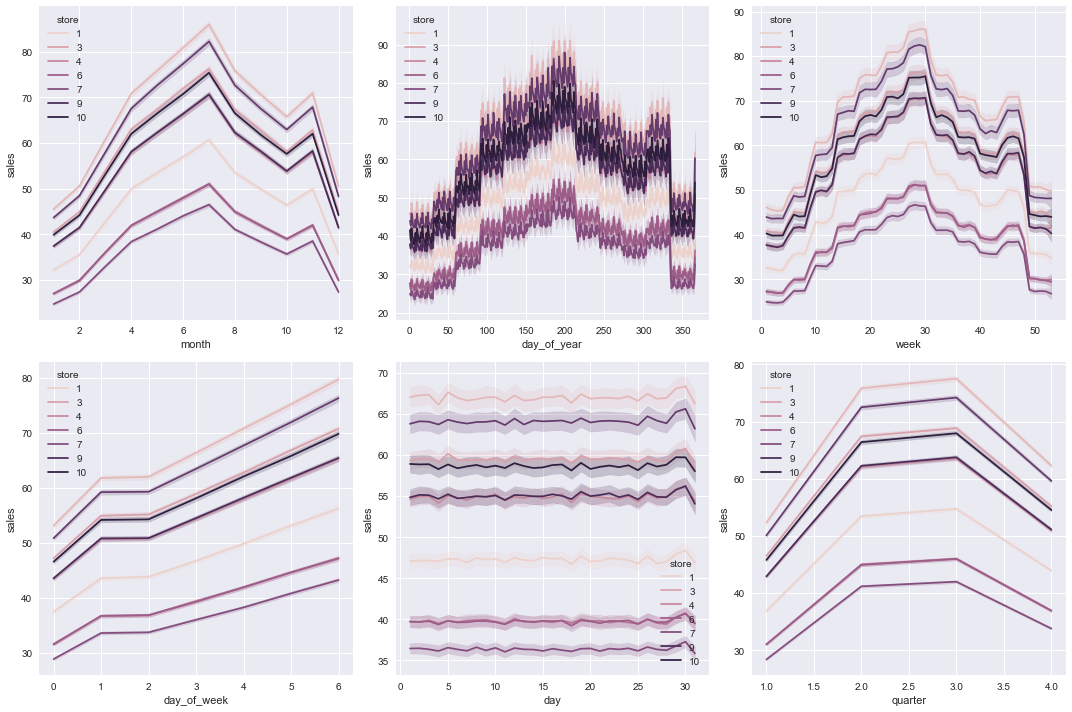

In [37]:
fig, ax = plt.subplots(nrows= 2, ncols=3, figsize = (15, 10))
cols = ['month', 'day', 'week', 'day_of_week', 'day_of_year', 'quarter']

for i in range(len(cols)):
    sns.lineplot(x=cols[i], y='sales', data=df_temp, hue='store', ax=ax[i % 2][i % 3])
plt.tight_layout()
plt.show()

From the charts, we can see a general increase in sales across all stores in the middle of the year. Sales are often low at the begining and at the end of the year. The sales pattern is the same for all the stores. Maybe, these stores are located in similar location or close proximity such that same factors such as economic state, weather, etc affects them alike. There would be a need for contextual information about the dataset to explain that observation. 

Looking at the days of the week, the weekends boast of more sales with the highest being sundays. Mondays have the lowest sales, followed by tuesday and wednesdays. The sales peak from thursday to sunday. Similarly we can observe the spike in sales every seven days from the days of the month chart. 

## 4.6 Lags Analysis

Sometimes, yesterdays or sales of a week ago might have impacted todays sales or even have telling influence on our prediction. In this section we will create intuitive lags such as sale of the previous day, cummulative sales of one week ago, a month ago as features.

In [109]:
def lags(df, lag_list):
    for lag in lag_list:
        df['Lag of ' + str(lag)] = df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag))
    return df

In [110]:
Lags = [1, 7, 30, 60, 90, 180]
df_temp= lags(df_temp, Lags)
df_temp.head()

,date,store,item,sales,year,month,day,week,day_of_week,day_of_year,quarter,Lag of 1,Lag of 7,Lag of 30,Lag of 60,Lag of 90,Lag of 180
0,2013-01-01,1,1,13,2013,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11,2013,1,2,1,2,2,1,13.0,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14,2013,1,3,1,3,3,1,11.0,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13,2013,1,4,1,4,4,1,14.0,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10,2013,1,5,1,5,5,1,13.0,NaN,NaN,NaN,NaN,NaN


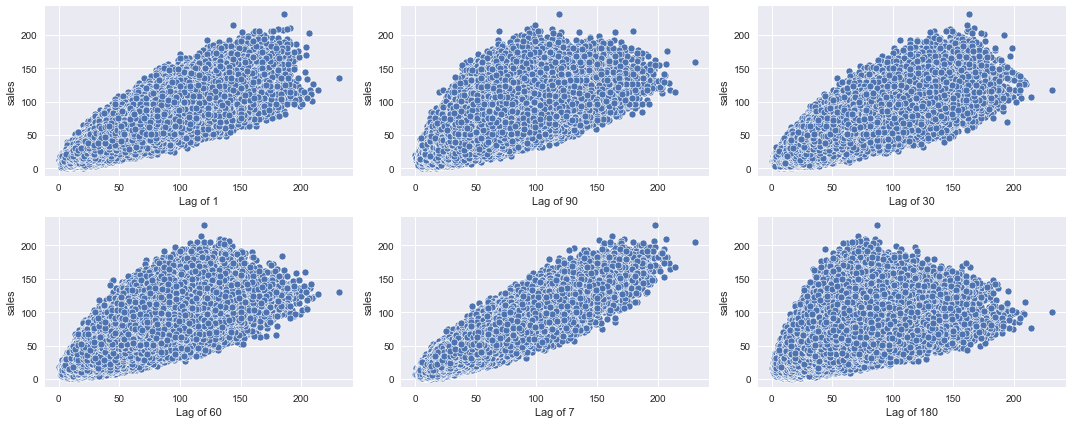

In [94]:
fig, ax = plt.subplots(nrows= 2, ncols=3, figsize = (15, 6))
cols = ['Lag of 1', 'Lag of 7', 'Lag of 30', 'Lag of 60', 'Lag of 90', 'Lag of 180']

for i in range(len(cols)):
    sns.scatterplot(x=cols[i], y='sales', data=df_temp, ax=ax[i % 2][i % 3])
plt.tight_layout()
plt.show()

Our inttuition was correct, there exist linear relationship between the current sale and the cummulative sales at a defined time lag. Meaning, if the sales yesterday was high, there is a higher chance that the sales today will be high too. The relationship is stronger in the first two months (within 60 days). Therefore it would impact the model to have lags within the first 60 days as features

## 4.6 Checking for Linearity and multi-colinearity

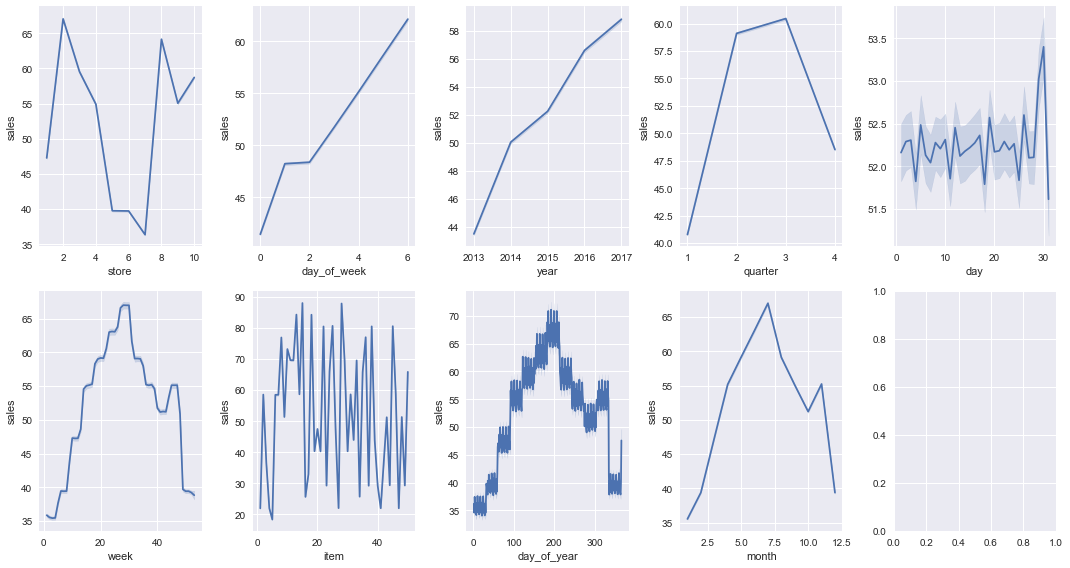

In [43]:
fig, ax = plt.subplots(nrows= 2, ncols=5, figsize = (15, 8))
cols = ['store', 'item', 'year', 'month', 'day', 'week', 'day_of_week', 'day_of_year', 'quarter']

for i in range(len(cols)):
    sns.lineplot(x=cols[i], y='sales', data=df_temp, ax=ax[i % 2][i % 5])
plt.tight_layout()
plt.show()

In [47]:
corr = df_temp.corr()
corr

,store,item,sales,year,month,day,week,day_of_week,day_of_year,quarter
store,1.000000e+00,7.276042e-15,-0.008170,1.349957e-13,-4.500688e-16,-4.920966e-16,-1.710955e-16,4.363596e-16,2.351305e-16,-5.633427e-16
item,7.276042e-15,1.000000e+00,-0.055998,1.908796e-11,4.093306e-15,-2.945987e-14,-7.805363e-15,1.643582e-14,4.282672e-15,-2.995440e-14
sales,-8.170361e-03,-5.599807e-02,1.000000,1.823597e-01,8.741417e-02,2.791264e-03,8.474468e-02,2.226076e-01,8.634719e-02,9.386691e-02
year,1.349957e-13,1.908796e-11,0.182360,1.000000e+00,-5.080291e-04,5.841665e-04,4.664350e-03,2.711688e-03,6.719189e-04,-5.231230e-04
month,-4.500688e-16,4.093306e-15,0.087414,-5.080291e-04,1.000000e+00,1.079604e-02,9.692253e-01,-1.475063e-03,9.965009e-01,9.713853e-01
day,-4.920966e-16,-2.945987e-14,0.002791,5.841665e-04,1.079604e-02,1.000000e+00,6.626610e-02,7.725204e-04,9.404329e-02,1.252828e-02
week,-1.710955e-16,-7.805363e-15,0.084745,4.664350e-03,9.692253e-01,6.626610e-02,1.000000e+00,-1.397624e-03,9.705337e-01,9.452676e-01
day_of_week,4.363596e-16,1.643582e-14,0.222608,2.711688e-03,-1.475063e-03,7.725204e-04,-1.397624e-03,1.000000e+00,-1.414220e-03,-1.109940e-03
day_of_year,2.351305e-16,4.282672e-15,0.086347,6.719189e-04,9.965009e-01,9.404329e-02,9.705337e-01,-1.414220e-03,1.000000e+00,9.682308e-01
quarter,-5.633427e-16,-2.995440e-14,0.093867,-5.231230e-04,9.713853e-01,1.252828e-02,9.452676e-01,-1.109940e-03,9.682308e-01,1.000000e+00


<AxesSubplot:>

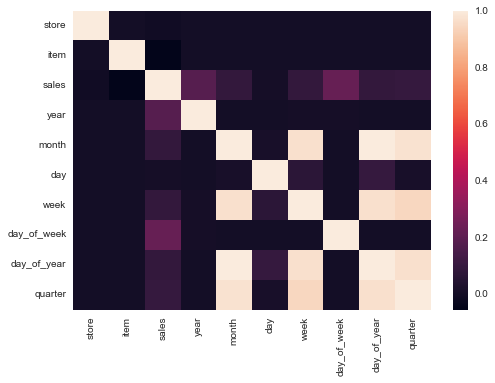

In [99]:
sns.heatmap(corr)

## 4.7 Summary of Exploratory Data Analysis

- The store and the items features have different scale and largely variant mean. Hence, there will be a need to scale the features

- Both store and items are uniformly distributed. Although, the target feature (sales) is slighly skewed to the right. Though, the values which falls extremely to the right are best not classified as outliers.

- There is a need to engineer more granular time related features. It has shown to have effect on the number of sales

<br>
<h2 style="background-color: blue; padding: 10px; color: white; font-size: 18pt; font-family: tahoma">
    5.0 DATA CLEANING AND FEATURE ENGINEERING
</h2>

From the Exploratory analysis, we can summarize the steps needed for the data cleaning and engineering phase as follows
1. Engineer seven new time related features - 'year', 'month', 'day', 'week', 'day_of_week', 'day_of_year', 'quarter'
2. Drop the initial date feature
3. Create Lag features for 1, 7, 30 and 60 days
4. Clean the dataset (handle missing values craeted by lag)
5. Split the dataset into predictors (X) and target (Y)
3. Scale the predictors

## 5.1 Engineering New time related features

We do have originally three predictors. Making do with those number of predictors puts the model at a risk of high variance. There is a chance that the model will overfit and will be unable to generalize. Hence, the need to create few more features. The date feature can be splitted into other time related features. Although, the EDA incated that they all have linear relationship with the target features and are colinear with each other. Hence, we might consider selecting the useful one by creating skeletal model and selecting the most influential features.

In [165]:
def create_time_features(df):
    ''' Returns a dataframe with new features added 
        
        Parameters
        ------------
        df: dataframe - takes a dataframe with date feature. 
        
        Return
        ------------
        df - Dataframe with new features added to it.
    '''
 
    df['year'] = df_temp.date.dt.year # Add year extracted from date feature
    df['month'] = df_temp.date.dt.month # Add month. Value range from 1 - 12.
    df['day'] = df_temp.date.dt.day # Add day of the month. Ranges between 1 - 31
    df['week'] = df_temp.date.dt.isocalendar().week # Add week of the year. Ranges from 1 - 53
    df['day_of_week'] = df_temp.date.dt.day_of_week # Add day of week. Ranges from 0 to 6
    df['day_of_year'] = df_temp.date.dt.day_of_year # Add day of year. Ranges from 1 to 366
    df['quarter'] = df_temp.date.dt.quarter # add quarter. Ranges from 1 - 4
    
    return df

In [167]:
df_cleaned = create_time_features(df_train.copy())
df_cleaned

,date,store,item,sales,year,month,day,week,day_of_week,day_of_year,quarter
0,2013-01-01,1,1,13,2013,1,1,1,1,1,1
1,2013-01-02,1,1,11,2013,1,2,1,2,2,1
2,2013-01-03,1,1,14,2013,1,3,1,3,3,1
3,2013-01-04,1,1,13,2013,1,4,1,4,4,1
4,2013-01-05,1,1,10,2013,1,5,1,5,5,1
...,...,...,...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,2017,12,27,52,2,361,4
912996,2017-12-28,10,50,59,2017,12,28,52,3,362,4
912997,2017-12-29,10,50,74,2017,12,29,52,4,363,4
912998,2017-12-30,10,50,62,2017,12,30,52,5,364,4


## 5.2 Drop the initial date feature

Since we have created new features from the date feature, we can drop that feature. If we must use them, they must be converted to numerical feature. Although, it is not necessary in this case.

In [168]:
df_cleaned.drop('date', axis=1, inplace=True)

In [169]:
df_cleaned.head()

,store,item,sales,year,month,day,week,day_of_week,day_of_year,quarter
0,1,1,13,2013,1,1,1,1,1,1
1,1,1,11,2013,1,2,1,2,2,1
2,1,1,14,2013,1,3,1,3,3,1
3,1,1,13,2013,1,4,1,4,4,1
4,1,1,10,2013,1,5,1,5,5,1


## 5.3 Create lag Features

We create the lag features for 1, 7, 30 and 60 days

In [107]:
def create_lag_features(df, lag_list):
    ''' Returns a dataframe with lag features as specified in lag_list added. 
        
        Parameters
        -----------
        df: dataframe - A dataframe containing sales record which the lag features will be added to.
        lag_list: A list - A list of integers containing the lag  
        
        Returns:
        -----------
        df: Dataframe - A dataframe with the added lag features
    '''
    for lag in lag_list:
        df['Lag of ' + str(lag)] = df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag))
    return df

In [108]:
Lags = [1, 7, 30, 60, 90, 180]
df_cleaned= create_lag_features(df_cleaned, Lags)
df_cleaned.head()

,store,item,sales,year,month,day,week,day_of_week,day_of_year,quarter,Lag of 1,Lag of 7,Lag of 30,Lag of 60,Lag of 90,Lag of 180
0,1,1,13,2013,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,11,2013,1,2,1,2,2,1,13.0,NaN,NaN,NaN,NaN,NaN
2,1,1,14,2013,1,3,1,3,3,1,11.0,NaN,NaN,NaN,NaN,NaN
3,1,1,13,2013,1,4,1,4,4,1,14.0,NaN,NaN,NaN,NaN,NaN
4,1,1,10,2013,1,5,1,5,5,1,13.0,NaN,NaN,NaN,NaN,NaN


## 5.3 Handle Missing Valsues

The null values are created because there are no values for the Lag. For an instance, there will be a null value entry for the first field when we request for a Lag. The lag in such instance does not exist because there are no previous records to lag on. For this scenario, we will handle the missing values by imputing them with 0s. 

In [170]:
df_cleaned = df_cleaned.fillna(0)
df_cleaned.head()

,store,item,sales,year,month,day,week,day_of_week,day_of_year,quarter
0,1,1,13,2013,1,1,1,1,1,1
1,1,1,11,2013,1,2,1,2,2,1
2,1,1,14,2013,1,3,1,3,3,1
3,1,1,13,2013,1,4,1,4,4,1
4,1,1,10,2013,1,5,1,5,5,1


In [171]:
df_cleaned.describe()

,store,item,sales,year,month,day,week,day_of_week,day_of_year,quarter
count,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287,2015.000548,6.523549,15.727820,26.615553,3.001643,183.100219,2.508762
std,2.872283,14.430878,28.801144,1.414021,3.448535,8.799329,15.060967,1.999316,105.424201,1.117020
min,1.000000,1.000000,0.000000,2013.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,3.000000,13.000000,30.000000,2014.000000,4.000000,8.000000,14.000000,1.000000,92.000000,2.000000
50%,5.500000,25.500000,47.000000,2015.000000,7.000000,16.000000,27.000000,3.000000,183.000000,3.000000
75%,8.000000,38.000000,70.000000,2016.000000,10.000000,23.000000,40.000000,5.000000,274.000000,4.000000
max,10.000000,50.000000,231.000000,2017.000000,12.000000,31.000000,53.000000,6.000000,366.000000,4.000000


## 5.4 Split Dataset into Predictors and Target

The training and test dataset should be splitted into thier respective predictors and target features.

In [172]:
def split(df, target):
    X = df.drop(target, axis=1)
    y = df[target]
    return X, y

In [173]:
df_X, df_y = split(df_cleaned, 'sales')

## 5.5 Standardizing the predictors

Considering the chart below, we can observe that all the features are in different scales from their mean values. If the dataset is used to train a model as it is, some features will unfairly affect the predictions than others.

Text(0.5, 0, 'features')

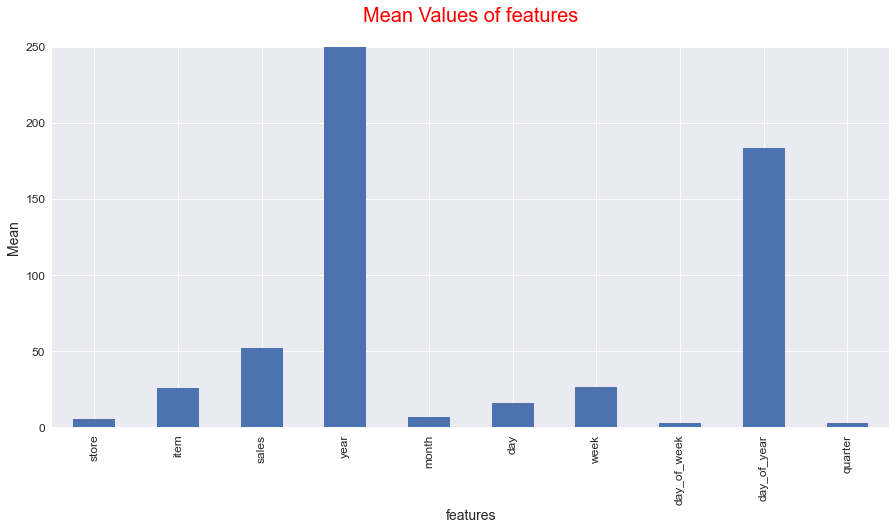

In [174]:
plt.style.use('seaborn')
df_cleaned.describe().T['mean'].plot(kind='bar', figsize=(15,7), fontsize=12)
plt.title("Mean Values of features", fontsize=20, color='red', y=1.05)
plt.ylim((0, 250))
plt.ylabel('Mean', fontsize=14)
plt.xlabel('features', fontsize=14)

### 5.4.1 Fitting a Standardizer Object

In [185]:
# fiting and saving a standardizer
def fit_scaler(predictors):
    scaler = StandardScaler()
    scaler = scaler.fit(predictors)
    with open('models/scaler.plk', 'wb') as f:
        pkl.dump(scaler, f)
        

fit_scaler(df_X)


### 5.4.2 Using a Standardizer Object

In [213]:
# use saved scaler
def scale_features(df):
    with open('models/scaler.plk', 'rb') as f:
        scaler = pkl.load(f)

    df_scaled = scaler.transform(df)
    return df_scaled

## 5.6 Function for performing Cleaning and Feature Engineering

To predict new sales, we will need to repeat the data cleaning and preprocessing steps on entered data. Sometimes, this steps might be needed on the deployment pipeline. Hence, a single utility function for cleaning for implementing the data cleaning and feature engineering will be handy. Hence, we will package all the steps into a single reusable function and save it in a pickle file.

In [214]:
def clean_data(df, lags = [1, 7, 30, 60, 90, 180], drop=['id', 'date'], split_data = False):
    
    # create time features
    df_cleaned = create_time_features(df)
    
    # drop the initial date feature
    df_cleaned = df_cleaned.drop(drop, axis=1)
    
    # create lag features
    #df_cleaned = create_lag_features(df_cleaned, lags)
    
    # fill missing values
    df_cleaned = df_cleaned.fillna(0)
    
    # split data if the purpose is for model training
    if split_data:
        try:
            df_X, df_y = split(df_cleaned, 'sales')
            scaled_X = scale_features(df_X)
        except:
            return ('Failed to split your dataset. Try passing in a dataframe with sales feature')
        
        return scaled_X, df_y
    else:
        return scale_features(df_cleaned)

In [215]:
# fiaveing the clean_data function
with open('models/clean_data.plk', 'wb') as f:
    pkl.dump(scaler, f)

In [217]:
y

0         13
1         11
2         14
3         13
4         10
          ..
912995    63
912996    59
912997    74
912998    62
912999    82
Name: sales, Length: 913000, dtype: int64